In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import torch
import torch.optim as optim
from utils import *
from tqdm import tqdm
import random

plt.rc('font', family='AppleGothic') 

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(0)

In [13]:
df = pd.read_csv('feature_extraction_v2.csv')

### 센서 데이터 조합별로 데이터 나누기

In [14]:
ACC_LIST = [i for i in range(2, 38)]
AE_LIST = [i for i in range(38, 50)]
FORCE_LIST = [i for i in range(50, 86)]

X_ACAE = df.iloc[:, ACC_LIST + AE_LIST].values
X_ACF = df.iloc[:, ACC_LIST + FORCE_LIST].values
X_AEF = df.iloc[:, AE_LIST + FORCE_LIST].values

X = df.iloc[:, ACC_LIST + AE_LIST + FORCE_LIST].values
y = df.iloc[:, -1].values

# Milling Condition 에 따른 데이터 나누기
t1_to_t4_indices = [i for i in range(0, 12*4)]
t5_indices = [i for i in range(12*4, 12*5)]
t6_indices = [i for i in range(12*5, 12*6)]
t7_indices = [i for i in range(12*6, 12*7)]
t8_indices = [i for i in range(12*7, 12*8)]


# Model (SVR, RFR, LSTM)

### SVR Model & RFR Model

In [15]:
class SVR_Model:
    def __init__(self, C=0.001, epsilon=0.1):
        self.svr_rbf = SVR(kernel='rbf', C=C, epsilon=epsilon)
    
    def train(self, X_train, y_train):
        print('SVR Training')
        self.svr_rbf.fit(X_train, y_train)
        print('SVR Training Done')

    def predict(self, X):
        y_pred = self.svr_rbf.predict(X)

        return y_pred

class RFR_Model:
    def __init__(self, n_estimators=500, random_state=42, min_samples_leaf=3, min_samples_split=2, bootstrap=True):
        self.rf_regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, bootstrap=bootstrap)
    
    def train(self, X_train, y_train):
        print('RFR Training')
        self.rf_regressor.fit(X_train, y_train)
        print('RFR Training Done')
    
    def predict(self, X):
        y_pred = self.rf_regressor.predict(X)

        return y_pred

### LSTM 모델

In [16]:
class _LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(_LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class LSTM_Model:
    def __init__(self, input_size, hidden_size, num_layers, output_size, learning_rate, gradient_threshold, epoch):
        self.model = _LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.1)
        self.epoch = epoch
        self.gradient_threshold = gradient_threshold

    def train(self, X_train, y_train):
        print('LSTM Training')
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
        
        self.model.train()
        for epoch in tqdm(range(self.epoch)):
            outputs = self.model(X_train_tensor)
            loss = self.criterion(outputs, y_train_tensor)
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gradient_threshold)
            
            self.optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.epoch}], Loss: {loss.item():.4f}')
            
            # self.scheduler.step()
        
        print('LSTM Training Done')

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor).detach().numpy()
        return y_pred

    def save_model(self, path):
        torch.save(self.model.state_dict(), f'{path}.pth')
        print("모델 상태 저장 완료")


# 실험

### 실험 설명
- T1, T2, T3, T4 데이터로 모델 학습
- T5, T6, T7, T8 각각을 Test Data로 결과 확인

In [17]:
def result_of_T5toT8(model_type, params, X, y):
    X_train = X[t1_to_t4_indices].copy()
    y_train = y[t1_to_t4_indices].copy()

    normalizer = Normalize()
    X_train, y_train = normalizer.fit_transform(X_train, y_train)


    if model_type == 'SVR':
        model = SVR_Model(**params)
    elif model_type == 'RFR':
        model = RFR_Model(**params)
    elif model_type == 'LSTM':
        model = LSTM_Model(**params)


    model.train(X_train, y_train)
    y_pred_train = model.predict(X_train)
    

    y_train_original = normalizer.inverse_normalize_data(y_train)
    y_pred_train_original = normalizer.inverse_normalize_data(y_pred_train)
    print(f'{model_type} Train RMSE: ', np.sqrt(mean_squared_error(y_train_original, y_pred_train_original)))
    print(f'{model_type} Train R2: ', r2_score(y_train_original, y_pred_train_original))

    # T5 결과
    X_test = X[t5_indices].copy()
    y_test = y[t5_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T5: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T5: ', r2_score(y_test_original, y_pred_test_original))
    t5_results = (y_test_original, y_pred_test_original)

    # T6 결과
    X_test = X[t6_indices].copy()
    y_test = y[t6_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T6: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T6: ', r2_score(y_test_original, y_pred_test_original))
    t6_results = (y_test_original, y_pred_test_original)

    # T7 결과
    X_test = X[t7_indices].copy()
    y_test = y[t7_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T7: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T7: ', r2_score(y_test_original, y_pred_test_original))
    t7_results = (y_test_original, y_pred_test_original)

    # T8 결과
    X_test = X[t8_indices].copy()
    y_test = y[t8_indices].copy()
    X_test, y_test = normalizer.normalize_data(X_test, y_test)
    y_pred_test = model.predict(X_test)
    y_test_original = normalizer.inverse_normalize_data(y_test)
    y_pred_test_original = normalizer.inverse_normalize_data(y_pred_test)

    print(f'{model_type} Test RMSE of T8: ', np.sqrt(mean_squared_error(y_test_original, y_pred_test_original)))
    print(f'{model_type} Test R2 of T8: ', r2_score(y_test_original, y_pred_test_original))
    t8_results = (y_test_original, y_pred_test_original)

    results = {
        'T5': t5_results,
        'T6': t6_results,
        'T7': t7_results,
        'T8': t8_results,
        'model': model,
    }

    return results


## 1. 전체 센서 데이터 모두 사용

### [SVR] 최적의 하이퍼파라미터를 찾기 위한 Grid Search 

In [18]:
X_train = X[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

svr = SVR()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)


print("Best Parameters:", svr_grid_search.best_params_)
print("Best Score:", svr_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: -0.26246144722043036


### [SVR] Grid Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [19]:
print(f'C: {svr_grid_search.best_params_["C"]}, epsilon: {svr_grid_search.best_params_["epsilon"]}')
C = svr_grid_search.best_params_['C']
epsilon = svr_grid_search.best_params_['epsilon']

svr_all_results = result_of_T5toT8('SVR', {'C': C, 'epsilon': epsilon}, X, y)

C: 0.1, epsilon: 0.1
SVR Training
SVR Training Done
SVR Train RMSE:  59.08802738133808
SVR Train R2:  0.2619372307791966
SVR Test RMSE of T5:  61.55002013603042
SVR Test R2 of T5:  0.19915085926802956
SVR Test RMSE of T6:  62.39652914634575
SVR Test R2 of T6:  0.17697092060846742
SVR Test RMSE of T7:  65.23669406846368
SVR Test R2 of T7:  0.1003404290388582
SVR Test RMSE of T8:  57.0912216265396
SVR Test R2 of T8:  0.31097816103684084


### [RFR] 최적의 하이퍼파라미터를 찾기 위한 Random Search 

In [20]:
X_train = X[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import RandomizedSearchCV

rff = RandomForestRegressor()

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

scoring = make_scorer(rmse, greater_is_better=False)

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

rfr_random_search = RandomizedSearchCV(estimator=rff, param_distributions=param_dist, n_iter=100, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1, random_state=42)
rfr_random_search.fit(X_train, y_train)


print("Best Parameters:", rfr_random_search.best_params_)
print("Best Score (Negative RMSE):", rfr_random_search.best_score_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Best Score (Negative RMSE): -0.25198976797722944


### [RFR] Random Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [21]:
# RFR
params = {
    'n_estimators': rfr_random_search.best_params_['n_estimators'],
    'min_samples_split': rfr_random_search.best_params_['min_samples_split'],
    'min_samples_leaf': rfr_random_search.best_params_['min_samples_leaf'],
    'bootstrap': rfr_random_search.best_params_['bootstrap'],
    'random_state': 42
}

print(params)

rfr_all_results = result_of_T5toT8('RFR', params, X, y)



{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}
RFR Training
RFR Training Done
RFR Train RMSE:  19.59574742101269
RFR Train R2:  0.9188258067228673
RFR Test RMSE of T5:  31.25212103716594
RFR Test R2 of T5:  0.7935317339588192
RFR Test RMSE of T6:  22.528882592759327
RFR Test R2 of T6:  0.8927064490651353
RFR Test RMSE of T7:  73.19570009203069
RFR Test R2 of T7:  -0.13257104215459803
RFR Test RMSE of T8:  21.318295186157997
RFR Test R2 of T8:  0.9039274632730162


### [LSTM] 최적의 하이퍼파라미터를 찾기 위한 Random Search

In [165]:
X_train = X[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Sklearn 래퍼 클래스 정의
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1, learning_rate=0.01, gradient_threshold=1, num_epochs=50):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.gradient_threshold = gradient_threshold
        self.model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        self.model.train()
        for epoch in range(self.num_epochs):
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(self.model.parameters(), self.gradient_threshold)
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions.detach().numpy()

# 하이퍼파라미터 분포 정의
param_dist = {
    'hidden_size': [100, 200, 500, 1000],
    'num_layers': [2, 3],
    'learning_rate': [0.001, 0.01],
    'gradient_threshold': [1, 1.5, 2],
    'num_epochs': [50, 100]
}

# LSTMRegressor 모델 초기화
lstm_regressor = LSTMRegressor(input_size=1)

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
lstm_random_search = RandomizedSearchCV(
    estimator=lstm_regressor, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=shuffle_split, 
    scoring=make_scorer(rmse, greater_is_better=False), 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# 모델 학습
lstm_random_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best Parameters:", lstm_random_search.best_params_)
print("Best Score (Negative RMSE):", lstm_random_search.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/admin/Desktop/크로이스/first project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'num_layers': 2, 'num_epochs': 50, 'learning_rate': 0.01, 'hidden_size': 200, 'gradient_threshold': 2}
Best Score (Negative RMSE): -0.2413271610143406


### [LSTM] Random Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [166]:
# LSTM
params = {
    'input_size': 1,
    'num_layers': lstm_random_search.best_params_['num_layers'],
    'hidden_size': lstm_random_search.best_params_['hidden_size'], 
    'epoch': lstm_random_search.best_params_['num_epochs'], 
    'gradient_threshold': lstm_random_search.best_params_['gradient_threshold'], 
    'output_size': 1,
    'learning_rate': lstm_random_search.best_params_['learning_rate'] 
}

print(params)

lstm_all_results = result_of_T5toT8('LSTM', params, X, y)
lstm_all_results['model'].save_model('lstm_all_model')


{'input_size': 1, 'num_layers': 2, 'hidden_size': 200, 'epoch': 50, 'gradient_threshold': 2, 'output_size': 1, 'learning_rate': 0.01}
LSTM Training


  0%|          | 0/50 [00:00<?, ?it/s]

 20%|██        | 10/50 [00:03<00:09,  4.36it/s]

Epoch [10/50], Loss: 0.1229


 42%|████▏     | 21/50 [00:05<00:06,  4.62it/s]

Epoch [20/50], Loss: 0.0832


 60%|██████    | 30/50 [00:07<00:04,  4.81it/s]

Epoch [30/50], Loss: 0.0795


 80%|████████  | 40/50 [00:09<00:02,  4.78it/s]

Epoch [40/50], Loss: 0.0747


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]

Epoch [50/50], Loss: 0.0608
LSTM Training Done
LSTM Train RMSE:  55.15532247834437
LSTM Train R2:  0.3569138275894581
LSTM Test RMSE of T5:  63.43534406095875
LSTM Test R2 of T5:  0.14933823134029545


LSTM Test RMSE of T6:  39.963803634592594
LSTM Test R2 of T6:  0.6623801691344254
LSTM Test RMSE of T7:  69.60687917347461
LSTM Test R2 of T7:  -0.024232707726656644
LSTM Test RMSE of T8:  52.432074650241354
LSTM Test R2 of T8:  0.41884978878816437
모델 상태 저장 완료


### 전체 센서 데이터를 활용한 결과 시각화

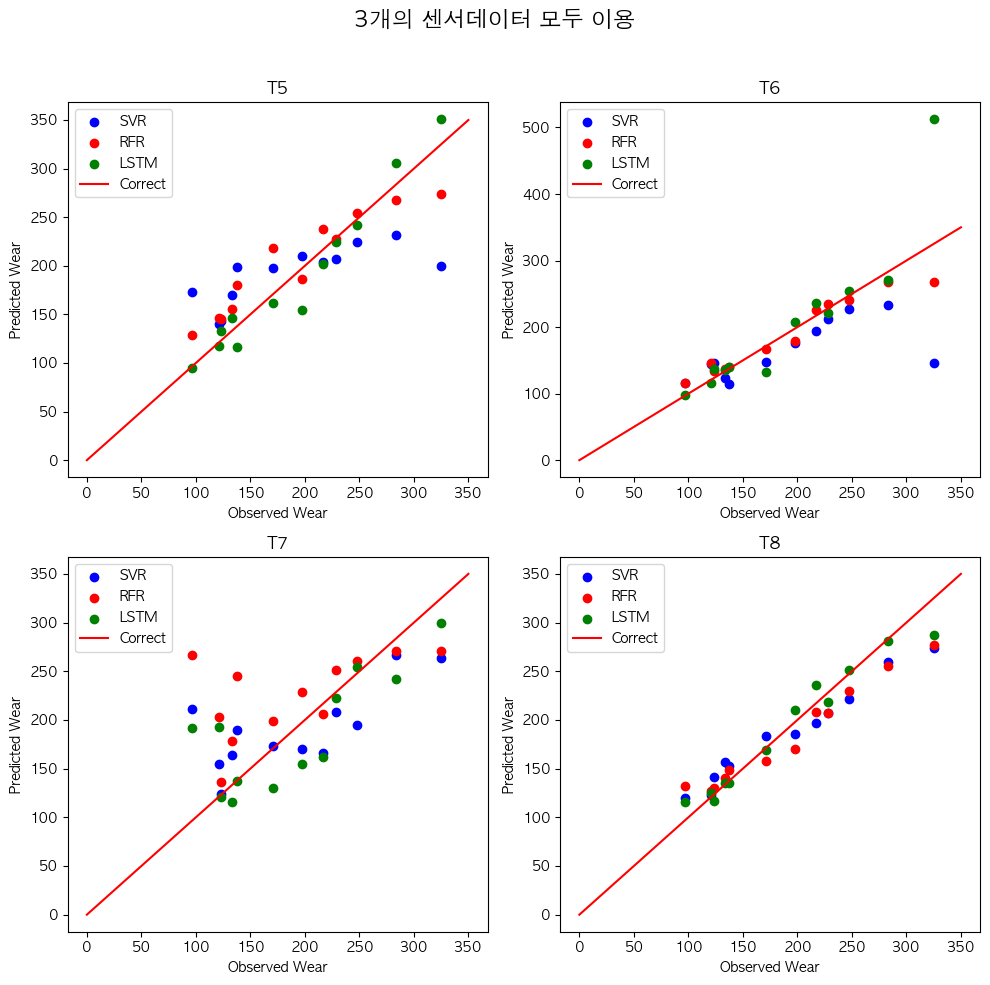

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    axs[i].scatter(svr_all_results[f'T{i+5}'][0], svr_all_results[f'T{i+5}'][1], label='SVR', color='blue')
    axs[i].scatter(rfr_all_results[f'T{i+5}'][0], rfr_all_results[f'T{i+5}'][1], label='RFR', color='red')
    axs[i].scatter(lstm_all_results[f'T{i+5}'][0], lstm_all_results[f'T{i+5}'][1], label='LSTM', color='green')
    axs[i].plot([0, 350], [0, 350], 'r-', label='Correct')
    axs[i].set_xlabel('Observed Wear')
    axs[i].set_ylabel('Predicted Wear')
    axs[i].legend()
    axs[i].set_title(f'T{i+5}')

fig.suptitle('3개의 센서데이터 모두 이용', fontsize=16)
# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

## 2. 2개 센서 데이터 이용 - Accelerometer & AE 

### [SVR] 최적의 하이퍼파라미터를 찾기 위한 Grid Search

In [34]:
X_train = X_ACAE[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACAE[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

svr = SVR()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)


print("Best Parameters:", svr_grid_search.best_params_)
print("Best Score:", svr_grid_search.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


Best Parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: -0.2091510026360437


### [SVR] Grid Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [35]:
params = {'C': svr_grid_search.best_params_["C"], "epsilon": svr_grid_search.best_params_["epsilon"]}
print(params)

svr_acae_results = result_of_T5toT8('SVR', params, X_ACAE, y)

{'C': 1, 'epsilon': 0.1}
SVR Training
SVR Training Done
SVR Train RMSE:  41.57884341958069
SVR Train R2:  0.6345406104838561
SVR Test RMSE of T5:  63.42284689993716
SVR Test R2 of T5:  0.1496733697424718
SVR Test RMSE of T6:  46.6977839328939
SVR Test R2 of T6:  0.5390149321490474
SVR Test RMSE of T7:  61.236720163149016
SVR Test R2 of T7:  0.20728302353303785
SVR Test RMSE of T8:  35.16216082559876
SVR Test R2 of T8:  0.7386362051479605


### [RFR] 최적의 하이퍼파라미터를 찾기 위한 Random Search

In [36]:
X_train = X_ACAE[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACAE[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import RandomizedSearchCV

rff = RandomForestRegressor()

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

rfr_random_search = RandomizedSearchCV(estimator=rff, param_distributions=param_dist, n_iter=100, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1, random_state=42)
rfr_random_search.fit(X_train, y_train)


print("Best Parameters:", rfr_random_search.best_params_)
print("Best Score (Negative RMSE):", rfr_random_search.best_score_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Best Score (Negative RMSE): -0.23770998002531177


### [RFR] Random Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [37]:
# RFR
params = {
    'n_estimators': rfr_random_search.best_params_['n_estimators'],
    'min_samples_split': rfr_random_search.best_params_['min_samples_split'],
    'min_samples_leaf': rfr_random_search.best_params_['min_samples_leaf'],
    'bootstrap': rfr_random_search.best_params_['bootstrap'],
    'random_state': 42
}

print(params)

rfr_acae_results = result_of_T5toT8('RFR', params, X_ACAE, y)

{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True, 'random_state': 42}
RFR Training
RFR Training Done
RFR Train RMSE:  20.226863554235678
RFR Train R2:  0.9135128860851709
RFR Test RMSE of T5:  47.012440911484674
RFR Test R2 of T5:  0.5327816230505038
RFR Test RMSE of T6:  23.40532249978983
RFR Test R2 of T6:  0.8841959963216924
RFR Test RMSE of T7:  64.89700647440657
RFR Test R2 of T7:  0.10968509498995382
RFR Test RMSE of T8:  33.513922458584304
RFR Test R2 of T8:  0.7625649463750472


### [LSTM] 최적의 하이퍼파라미터를 찾기 위한 Random Search

In [ ]:
X_train = X_ACAE[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACAE[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Sklearn 래퍼 클래스 정의
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1, learning_rate=0.01, gradient_threshold=1, num_epochs=50):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.gradient_threshold = gradient_threshold
        self.model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        self.model.train()
        for epoch in range(self.num_epochs):
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(self.model.parameters(), self.gradient_threshold)
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions.detach().numpy()


# 하이퍼파라미터 분포 정의
param_dist = {
    'hidden_size': [100, 200, 500, 1000],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'gradient_threshold': [0.5, 1, 1.5],
    'num_epochs': [50, 100, 200]
}

# LSTMRegressor 모델 초기화
lstm_regressor = LSTMRegressor(input_size=1)

shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# RandomizedSearchCV 객체 생성
lstm_random_search = RandomizedSearchCV(estimator=lstm_regressor, param_distributions=param_dist, n_iter=100, cv=shuffle_split, scoring=make_scorer(rmse, greater_is_better=False), verbose=1, n_jobs=-1, random_state=42)

# 모델 학습
lstm_random_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best Parameters:", lstm_random_search.best_params_)
print("Best Score (Negative RMSE):", lstm_random_search.best_score_)

### [LSTM] Random Search를 통해 찾은 최적의 하이퍼파라미터로 모델 생성

In [167]:

# LSTM
params = {
    'input_size': 1,
    'num_layers': 3,
    'hidden_size': 100,
    'epoch': 200, # 100
    'gradient_threshold': 0.5, # 0.5
    'output_size': 1,
    'learning_rate': 0.01
}


print(params)

lstm_acae_results = result_of_T5toT8('LSTM', params, X_ACAE, y)
lstm_acae_results['model'].save_model('lstm_acae_model')

{'input_size': 1, 'num_layers': 3, 'hidden_size': 100, 'epoch': 200, 'gradient_threshold': 0.5, 'output_size': 1, 'learning_rate': 0.01}
LSTM Training


  6%|▌         | 11/200 [00:01<00:22,  8.36it/s]

Epoch [10/200], Loss: 0.0927


 11%|█         | 22/200 [00:02<00:16, 10.98it/s]

Epoch [20/200], Loss: 0.0901


 15%|█▌        | 30/200 [00:03<00:14, 11.59it/s]

Epoch [30/200], Loss: 0.0861


 21%|██        | 42/200 [00:04<00:13, 11.45it/s]

Epoch [40/200], Loss: 0.0864


 25%|██▌       | 50/200 [00:05<00:13, 10.97it/s]

Epoch [50/200], Loss: 0.0916


 31%|███       | 62/200 [00:06<00:13, 10.59it/s]

Epoch [60/200], Loss: 0.0876


 36%|███▌      | 72/200 [00:07<00:11, 11.19it/s]

Epoch [70/200], Loss: 0.0844


 40%|████      | 80/200 [00:08<00:11, 10.13it/s]

Epoch [80/200], Loss: 0.0809


 46%|████▌     | 91/200 [00:09<00:11,  9.57it/s]

Epoch [90/200], Loss: 0.0838


 50%|█████     | 101/200 [00:10<00:10,  9.78it/s]

Epoch [100/200], Loss: 0.0736


 56%|█████▌    | 111/200 [00:11<00:08, 10.51it/s]

Epoch [110/200], Loss: 0.0661


 60%|██████    | 121/200 [00:12<00:13,  5.82it/s]

Epoch [120/200], Loss: 0.0667


 66%|██████▌   | 131/200 [00:14<00:11,  5.89it/s]

Epoch [130/200], Loss: 0.0625


 70%|███████   | 141/200 [00:15<00:08,  7.28it/s]

Epoch [140/200], Loss: 0.0494


 76%|███████▌  | 151/200 [00:16<00:05,  8.47it/s]

Epoch [150/200], Loss: 0.0453


 81%|████████  | 162/200 [00:17<00:03, 10.75it/s]

Epoch [160/200], Loss: 0.0521


 85%|████████▌ | 170/200 [00:18<00:02, 11.49it/s]

Epoch [170/200], Loss: 0.0342


 90%|█████████ | 180/200 [00:19<00:02,  9.71it/s]

Epoch [180/200], Loss: 0.0188


 96%|█████████▌| 191/200 [00:20<00:00,  9.68it/s]

Epoch [190/200], Loss: 0.0101


100%|██████████| 200/200 [00:21<00:00,  9.12it/s]


Epoch [200/200], Loss: 0.0112
LSTM Training Done
LSTM Train RMSE:  29.65139301338616
LSTM Train R2:  0.8141406056305017
LSTM Test RMSE of T5:  30.17492037848072
LSTM Test R2 of T5:  0.8075195697053796
LSTM Test RMSE of T6:  39.68001062487514
LSTM Test R2 of T6:  0.6671581901980179
LSTM Test RMSE of T7:  38.46186420442636
LSTM Test R2 of T7:  0.6872804909372968
LSTM Test RMSE of T8:  29.411204887888932
LSTM Test R2 of T8:  0.8171394808378899
모델 상태 저장 완료


### 결과 시각화

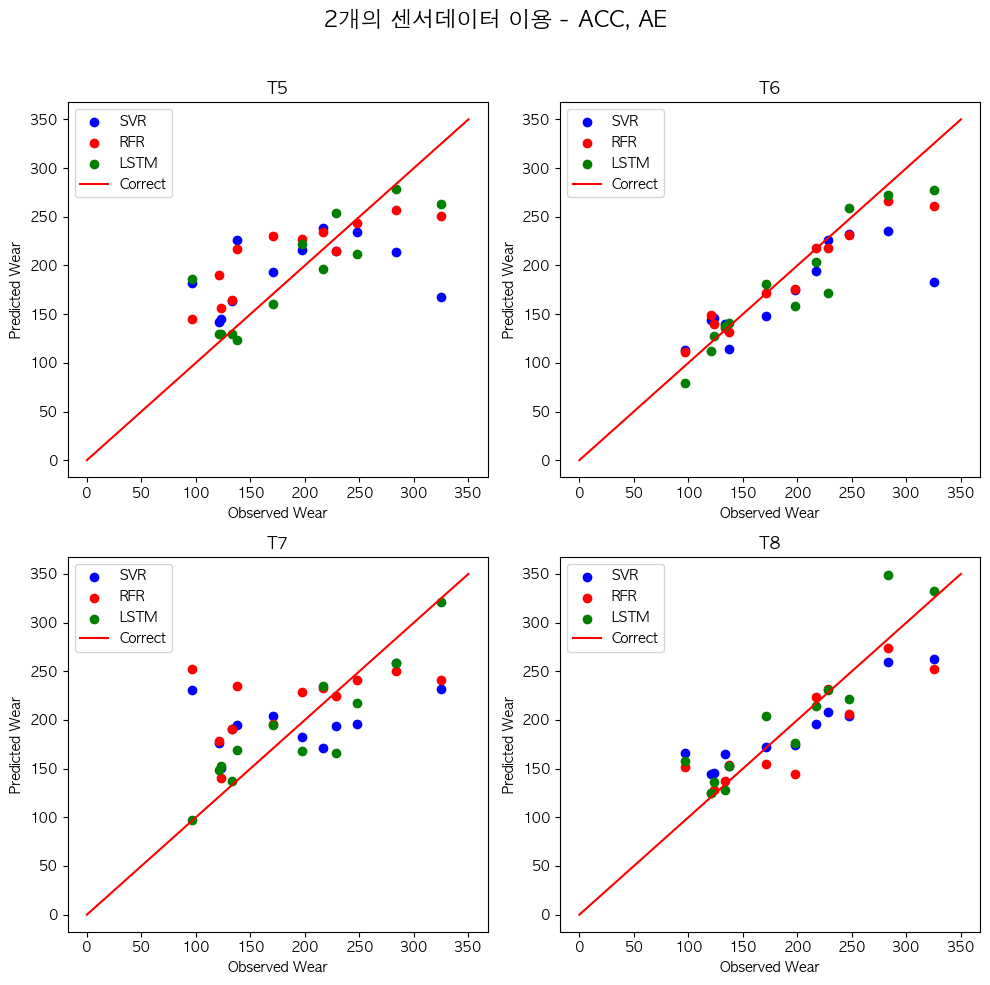

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    axs[i].scatter(svr_acae_results[f'T{i+5}'][0], svr_acae_results[f'T{i+5}'][1], label='SVR', color='blue')
    axs[i].scatter(rfr_acae_results[f'T{i+5}'][0], rfr_acae_results[f'T{i+5}'][1], label='RFR', color='red')
    axs[i].scatter(lstm_acae_results[f'T{i+5}'][0], lstm_acae_results[f'T{i+5}'][1], label='LSTM', color='green')
    axs[i].plot([0, 350], [0, 350], 'r-', label='Correct')
    axs[i].set_xlabel('Observed Wear')
    axs[i].set_ylabel('Predicted Wear')
    axs[i].legend()
    axs[i].set_title(f'T{i+5}')

fig.suptitle('2개의 센서데이터 이용 - ACC, AE', fontsize=16)
# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

# 3. 2개의 센서데이터 이용 - Accelerometer & Force

### SVR

In [69]:
X_train = X_ACF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

svr = SVR()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)


print("Best Parameters:", svr_grid_search.best_params_)
print("Best Score:", svr_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: -0.2488864503776285


In [70]:
params = {'C': svr_grid_search.best_params_["C"], "epsilon": svr_grid_search.best_params_["epsilon"]}
print(params)

svr_acf_results = result_of_T5toT8('SVR', params, X_ACF, y)

{'C': 1, 'epsilon': 0.1}
SVR Training
SVR Training Done
SVR Train RMSE:  35.27245474037077
SVR Train R2:  0.7369939825815449
SVR Test RMSE of T5:  52.13159368963874
SVR Test R2 of T5:  0.42549168500353485
SVR Test RMSE of T6:  57.08096916057373
SVR Test R2 of T6:  0.3112256084887913
SVR Test RMSE of T7:  47.575228591982594
SVR Test R2 of T7:  0.5215284908073412
SVR Test RMSE of T8:  34.30612555780053
SVR Test R2 of T8:  0.7512072842397317


### RFR

In [71]:
X_train = X_ACF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import RandomizedSearchCV

rff = RandomForestRegressor()

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True, False]
}

scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

rfr_random_search = RandomizedSearchCV(estimator=rff, param_distributions=param_dist, n_iter=100, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1, random_state=42)
rfr_random_search.fit(X_train, y_train)


print("Best Parameters:", rfr_random_search.best_params_)
print("Best Score (Negative RMSE):", rfr_random_search.best_score_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True}
Best Score (Negative RMSE): -0.2501588447698528


In [72]:
# RFR
params = {
    'n_estimators': rfr_random_search.best_params_['n_estimators'],
    'min_samples_split': rfr_random_search.best_params_['min_samples_split'],
    'min_samples_leaf': rfr_random_search.best_params_['min_samples_leaf'],
    'bootstrap': rfr_random_search.best_params_['bootstrap'],
    'random_state': 42
}

print(params)

rfr_acf_results = result_of_T5toT8('RFR', params, X_ACF, y)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True, 'random_state': 42}
RFR Training
RFR Training Done
RFR Train RMSE:  30.864316247264277
RFR Train R2:  0.7986240344472377
RFR Test RMSE of T5:  37.013248831236446
RFR Test R2 of T5:  0.7103932172748264
RFR Test RMSE of T6:  28.118149617362494
RFR Test R2 of T6:  0.8328648520156413
RFR Test RMSE of T7:  69.67950444931948
RFR Test R2 of T7:  -0.026371116723108212
RFR Test RMSE of T8:  32.1816013919189
RFR Test R2 of T8:  0.7810678118062305


### LSTM

In [ ]:
X_train = X_ACF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Sklearn 래퍼 클래스 정의
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1, learning_rate=0.01, gradient_threshold=1, num_epochs=50):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.gradient_threshold = gradient_threshold
        self.model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        self.model.train()
        for epoch in range(self.num_epochs):
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(self.model.parameters(), self.gradient_threshold)
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions.detach().numpy()

# 하이퍼파라미터 분포 정의
param_dist = {
    'hidden_size': [100, 200, 500, 1000],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'gradient_threshold': [0.5, 1, 1.5],
    'num_epochs': [50, 100, 200]
}

# LSTMRegressor 모델 초기화
lstm_regressor = LSTMRegressor(input_size=1)

# RandomizedSearchCV 객체 생성
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
lstm_random_search = RandomizedSearchCV(estimator=lstm_regressor, param_distributions=param_dist, n_iter=100, cv=shuffle_split, scoring=make_scorer(rmse, greater_is_better=False), verbose=1, n_jobs=-1, random_state=42)

# 모델 학습
lstm_random_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best Parameters:", lstm_random_search.best_params_)
print("Best Score (Negative RMSE):", lstm_random_search.best_score_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] END gradient_threshold=1, hidden_size=200, learning_rate=0.001, num_epochs=10, num_layers=1; total time=   0.5s
[CV] END gradient_threshold=1, hidden_size=200, learning_rate=0.001, num_epochs=10, num_layers=1; total time=   0.5s
[CV] END gradient_threshold=2, hidden_size=1000, learning_rate=0.1, num_epochs=50, num_layers=2; total time=   2.3s
[CV] END gradient_threshold=2, hidden_size=1000, learning_rate=0.1, num_epochs=50, num_layers=2; total time=   2.5s
[CV] END gradient_threshold=0.5, hidden_size=500, learning_rate=0.001, num_epochs=50, num_layers=1; total time=   2.5s
[CV] END gradient_threshold=0.5, hidden_size=500, learning_rate=0.001, num_epochs=50, num_layers=1; total time=   2.5s
[CV] END gradient_threshold=0.5, hidden_size=100, learning_rate=0.1, num_epochs=100, num_layers=1; total time=   5.2s
[CV] END gradient_threshold=0.5, hidden_size=100, learning_rate=0.1, num_epochs=100, num_layers=1; total time=   5.

In [168]:

# LSTM
params = {
    'input_size': 1,
    'num_layers': 3,
    'hidden_size': 100,
    'epoch': 200, # 100
    'gradient_threshold': 0.5, # 0.5
    'output_size': 1,
    'learning_rate': 0.01
}

print(params)

lstm_acf_results = result_of_T5toT8('LSTM', params, X_ACF, y)
lstm_acf_results['model'].save_model('lstm_acf_model')

{'input_size': 1, 'num_layers': 3, 'hidden_size': 100, 'epoch': 200, 'gradient_threshold': 0.5, 'output_size': 1, 'learning_rate': 0.01}
LSTM Training


  5%|▌         | 10/200 [00:01<00:48,  3.92it/s]

Epoch [10/200], Loss: 0.0940


 10%|█         | 21/200 [00:03<00:28,  6.26it/s]

Epoch [20/200], Loss: 0.0912


 16%|█▌        | 31/200 [00:05<00:25,  6.51it/s]

Epoch [30/200], Loss: 0.0857


 20%|██        | 41/200 [00:06<00:26,  6.00it/s]

Epoch [40/200], Loss: 0.0914


 26%|██▌       | 51/200 [00:08<00:25,  5.88it/s]

Epoch [50/200], Loss: 0.0961


 30%|███       | 61/200 [00:09<00:22,  6.27it/s]

Epoch [60/200], Loss: 0.0916


 36%|███▌      | 71/200 [00:11<00:30,  4.20it/s]

Epoch [70/200], Loss: 0.0910


 40%|████      | 81/200 [00:13<00:16,  7.12it/s]

Epoch [80/200], Loss: 0.0907


 46%|████▌     | 91/200 [00:14<00:16,  6.73it/s]

Epoch [90/200], Loss: 0.0906


 50%|█████     | 101/200 [00:15<00:13,  7.41it/s]

Epoch [100/200], Loss: 0.0906


 56%|█████▌    | 111/200 [00:17<00:12,  6.98it/s]

Epoch [110/200], Loss: 0.0905


 60%|██████    | 121/200 [00:18<00:10,  7.29it/s]

Epoch [120/200], Loss: 0.0902


 66%|██████▌   | 131/200 [00:19<00:09,  7.33it/s]

Epoch [130/200], Loss: 0.0874


 70%|███████   | 141/200 [00:21<00:08,  7.33it/s]

Epoch [140/200], Loss: 0.0926


 76%|███████▌  | 151/200 [00:22<00:05,  8.46it/s]

Epoch [150/200], Loss: 0.0933


 80%|████████  | 161/200 [00:23<00:06,  6.45it/s]

Epoch [160/200], Loss: 0.0915


 86%|████████▌ | 171/200 [00:25<00:04,  6.91it/s]

Epoch [170/200], Loss: 0.0907


 90%|█████████ | 181/200 [00:26<00:02,  7.81it/s]

Epoch [180/200], Loss: 0.0905


 96%|█████████▌| 191/200 [00:28<00:01,  5.84it/s]

Epoch [190/200], Loss: 0.0905


100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Epoch [200/200], Loss: 0.0903
LSTM Training Done
LSTM Train RMSE:  68.6037384642684
LSTM Train R2:  0.005076061288269207
LSTM Test RMSE of T5:  68.5237406924206
LSTM Test R2 of T5:  0.0073950396618579495
LSTM Test RMSE of T6:  65.70147548437264
LSTM Test R2 of T6:  0.08747544252418449
LSTM Test RMSE of T7:  68.71371037922572
LSTM Test R2 of T7:  0.0018837750251922136
LSTM Test RMSE of T8:  68.72078491100025
LSTM Test R2 of T8:  0.0016782390875106357
모델 상태 저장 완료


### 결과 시각화

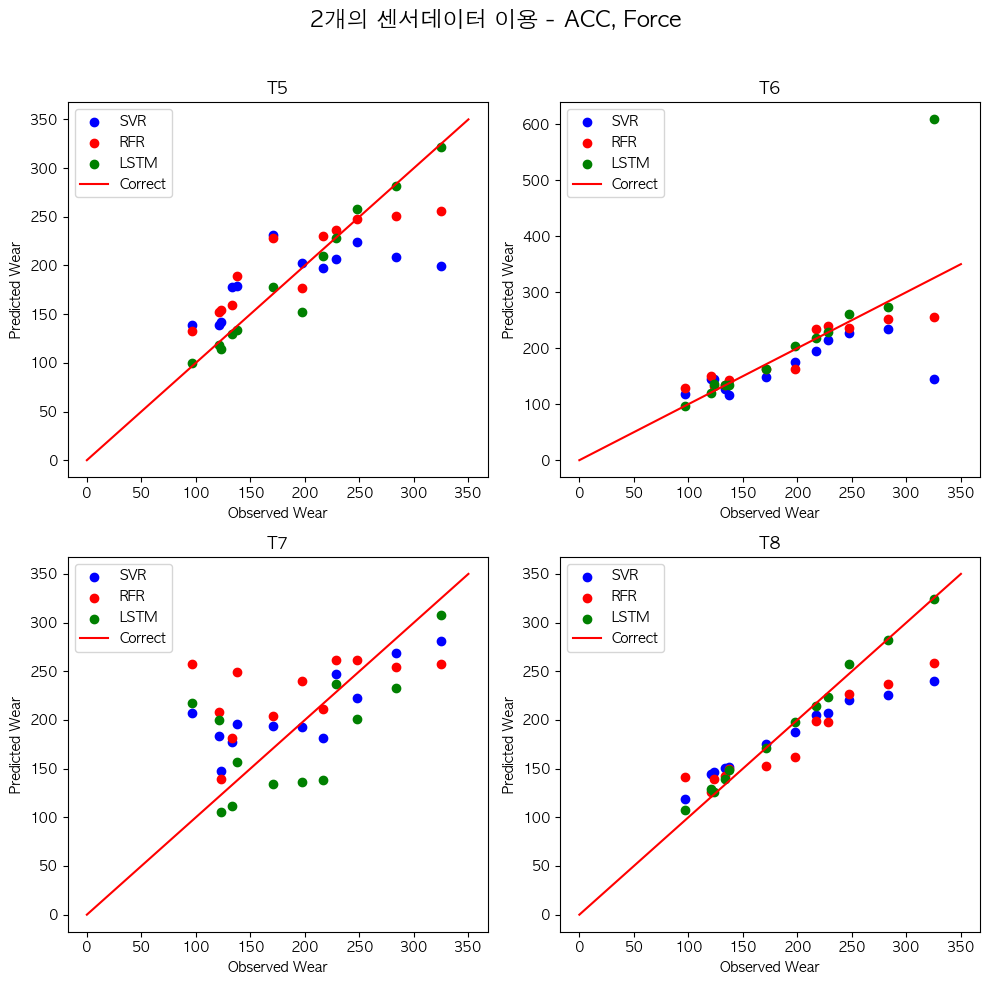

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    axs[i].scatter(svr_acf_results[f'T{i+5}'][0], svr_acf_results[f'T{i+5}'][1], label='SVR', color='blue')
    axs[i].scatter(rfr_acf_results[f'T{i+5}'][0], rfr_acf_results[f'T{i+5}'][1], label='RFR', color='red')
    axs[i].scatter(lstm_acf_results[f'T{i+5}'][0], lstm_acf_results[f'T{i+5}'][1], label='LSTM', color='green')
    axs[i].plot([0, 350], [0, 350], 'r-', label='Correct')
    axs[i].set_xlabel('Observed Wear')
    axs[i].set_ylabel('Predicted Wear')
    axs[i].legend()
    axs[i].set_title(f'T{i+5}')

fig.suptitle('2개의 센서데이터 이용 - ACC, Force', fontsize=16)
# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

# 4. 2개의 센서데이터 이용 - AE, Force

### SVR

In [75]:
X_train = X_AEF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_AEF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

svr = SVR()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)


print("Best Parameters:", svr_grid_search.best_params_)
print("Best Score:", svr_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: -0.2779353168975036


In [76]:
params = {'C': svr_grid_search.best_params_["C"], "epsilon": svr_grid_search.best_params_["epsilon"]}
print(params)

svr_aef_results = result_of_T5toT8('SVR', params, X_AEF, y)

{'C': 0.1, 'epsilon': 0.1}
SVR Training
SVR Training Done
SVR Train RMSE:  57.490533701525756
SVR Train R2:  0.3013060287099334
SVR Test RMSE of T5:  57.8393272086094
SVR Test R2 of T5:  0.2928023963625813
SVR Test RMSE of T6:  64.73275971811022
SVR Test R2 of T6:  0.11418595861787639
SVR Test RMSE of T7:  60.151029042155656
SVR Test R2 of T7:  0.23514266095788605
SVR Test RMSE of T8:  50.519438883488355
SVR Test R2 of T8:  0.4604752754357305


### RFR

In [77]:
X_train = X_AEF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_AEF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

svr = SVR()

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
scoring = make_scorer(rmse, greater_is_better=False)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scoring, cv=shuffle_split, verbose=1, n_jobs=-1)
svr_grid_search.fit(X_train, y_train)


print("Best Parameters:", svr_grid_search.best_params_)
print("Best Score:", svr_grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}
Best Score: -0.2779353168975036


In [78]:
# RFR
params = {
    'n_estimators': rfr_random_search.best_params_['n_estimators'],
    'min_samples_split': rfr_random_search.best_params_['min_samples_split'],
    'min_samples_leaf': rfr_random_search.best_params_['min_samples_leaf'],
    'bootstrap': rfr_random_search.best_params_['bootstrap'],
    'random_state': 42
}

print(params)

rfr_aef_results = result_of_T5toT8('RFR', params, X_AEF, y)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True, 'random_state': 42}
RFR Training
RFR Training Done
RFR Train RMSE:  33.94923331005025
RFR Train R2:  0.7563568212540963
RFR Test RMSE of T5:  34.178983263631935
RFR Test R2 of T5:  0.7530479736299895
RFR Test RMSE of T6:  28.026121719540043
RFR Test R2 of T6:  0.833957095006984
RFR Test RMSE of T7:  60.99942952698502
RFR Test R2 of T7:  0.21341463429119623
RFR Test RMSE of T8:  31.098559552219722
RFR Test R2 of T8:  0.7955557680202308


### LSTM

In [ ]:
X_train = X_ACF[t1_to_t4_indices].copy()
y_train = y[t1_to_t4_indices].copy()
X_test = X_ACF[t5_indices].copy()
y_test = y[t5_indices].copy()

normalizer = Normalize()
X_train, y_train = normalizer.fit_transform(X_train, y_train)
X_test, y_test = normalizer.normalize_data(X_test, y_test)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Sklearn 래퍼 클래스 정의
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1, learning_rate=0.01, gradient_threshold=1, num_epochs=50):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.gradient_threshold = gradient_threshold
        self.model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.num_epochs = num_epochs

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        self.model.train()
        for epoch in range(self.num_epochs):
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(self.model.parameters(), self.gradient_threshold)
            self.optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions.detach().numpy()

# 하이퍼파라미터 분포 정의
param_dist = {
    'hidden_size': [100, 200, 500, 1000],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.001, 0.01, 0.1],
    'gradient_threshold': [0.5, 1, 2],
    'num_epochs': [10, 50, 100, 200]
}

# LSTMRegressor 모델 초기화
lstm_regressor = LSTMRegressor(input_size=1)

# RandomizedSearchCV 객체 생성
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
lstm_random_search = RandomizedSearchCV(estimator=lstm_regressor, param_distributions=param_dist, n_iter=100, cv=shuffle_split, scoring=make_scorer(rmse, greater_is_better=False), verbose=1, n_jobs=-1, random_state=42)

# 모델 학습
lstm_random_search.fit(X_train, y_train)

# 최적 파라미터와 점수 출력
print("Best Parameters:", lstm_random_search.best_params_)
print("Best Score (Negative RMSE):", lstm_random_search.best_score_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV] END gradient_threshold=1, hidden_size=200, learning_rate=0.001, num_epochs=10, num_layers=1; total time=   0.5s
[CV] END gradient_threshold=1, hidden_size=200, learning_rate=0.001, num_epochs=10, num_layers=1; total time=   0.5s
[CV] END gradient_threshold=2, hidden_size=1000, learning_rate=0.1, num_epochs=50, num_layers=2; total time=   2.4s
[CV] END gradient_threshold=2, hidden_size=1000, learning_rate=0.1, num_epochs=50, num_layers=2; total time=   2.5s
[CV] END gradient_threshold=0.5, hidden_size=500, learning_rate=0.001, num_epochs=50, num_layers=1; total time=   2.5s
[CV] END gradient_threshold=0.5, hidden_size=500, learning_rate=0.001, num_epochs=50, num_layers=1; total time=   2.6s
[CV] END gradient_threshold=0.5, hidden_size=100, learning_rate=0.1, num_epochs=100, num_layers=1; total time=   5.1s
[CV] END gradient_threshold=0.5, hidden_size=100, learning_rate=0.1, num_epochs=100, num_layers=1; total time=   5.

In [169]:

# LSTM
params = {
    'input_size': 1,
    'num_layers': 3,
    'hidden_size': 100,
    'epoch': 200, # 100
    'gradient_threshold': 0.5, # 0.5
    'output_size': 1,
    'learning_rate': 0.01
}

print(params)

lstm_aef_results = result_of_T5toT8('LSTM', params, X_AEF, y)
lstm_aef_results['model'].save_model('lstm_aef_model')

{'input_size': 1, 'num_layers': 3, 'hidden_size': 100, 'epoch': 200, 'gradient_threshold': 0.5, 'output_size': 1, 'learning_rate': 0.01}
LSTM Training


  0%|          | 0/200 [00:00<?, ?it/s]

  6%|▌         | 11/200 [00:01<00:18, 10.22it/s]

Epoch [10/200], Loss: 0.0979


 10%|█         | 21/200 [00:02<00:19,  9.10it/s]

Epoch [20/200], Loss: 0.0913


 16%|█▌        | 31/200 [00:03<00:15, 10.95it/s]

Epoch [30/200], Loss: 0.0779


 20%|██        | 41/200 [00:04<00:14, 10.81it/s]

Epoch [40/200], Loss: 0.0635


 26%|██▌       | 51/200 [00:05<00:13, 11.23it/s]

Epoch [50/200], Loss: 0.0502


 30%|██▉       | 59/200 [00:05<00:12, 11.37it/s]

Epoch [60/200], Loss: 0.0309


 36%|███▌      | 71/200 [00:07<00:13,  9.48it/s]

Epoch [70/200], Loss: 0.0351


 40%|████      | 81/200 [00:08<00:13,  9.07it/s]

Epoch [80/200], Loss: 0.0168


 46%|████▌     | 92/200 [00:09<00:09, 10.88it/s]

Epoch [90/200], Loss: 0.0092


 51%|█████     | 102/200 [00:10<00:09, 10.86it/s]

Epoch [100/200], Loss: 0.0060


 56%|█████▌    | 112/200 [00:11<00:07, 11.43it/s]

Epoch [110/200], Loss: 0.0037


 61%|██████    | 122/200 [00:12<00:07, 10.60it/s]

Epoch [120/200], Loss: 0.0022


 66%|██████▌   | 132/200 [00:13<00:06, 10.87it/s]

Epoch [130/200], Loss: 0.0143


 70%|███████   | 141/200 [00:14<00:06,  9.07it/s]

Epoch [140/200], Loss: 0.0053


 76%|███████▌  | 151/200 [00:15<00:04, 10.70it/s]

Epoch [150/200], Loss: 0.0026


 80%|████████  | 161/200 [00:16<00:03, 11.09it/s]

Epoch [160/200], Loss: 0.0018


 86%|████████▌ | 171/200 [00:17<00:02, 10.63it/s]

Epoch [170/200], Loss: 0.0014


 90%|█████████ | 181/200 [00:18<00:02,  9.12it/s]

Epoch [180/200], Loss: 0.0010


 94%|█████████▍| 189/200 [00:19<00:01, 10.53it/s]

Epoch [190/200], Loss: 0.0008


100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


Epoch [200/200], Loss: 0.0006
LSTM Training Done
LSTM Train RMSE:  5.55303562360939
LSTM Train R2:  0.9934813864606384
LSTM Test RMSE of T5:  8.241781148703698
LSTM Test R2 of T5:  0.9856405941146034
LSTM Test RMSE of T6:  20.902978325448483
LSTM Test R2 of T6:  0.9076343149304015
LSTM Test RMSE of T7:  93.52091878998257
LSTM Test R2 of T7:  -0.8488932843692458
LSTM Test RMSE of T8:  8.281239906362066
LSTM Test R2 of T8:  0.9855027693754893
모델 상태 저장 완료


### 결과시각화

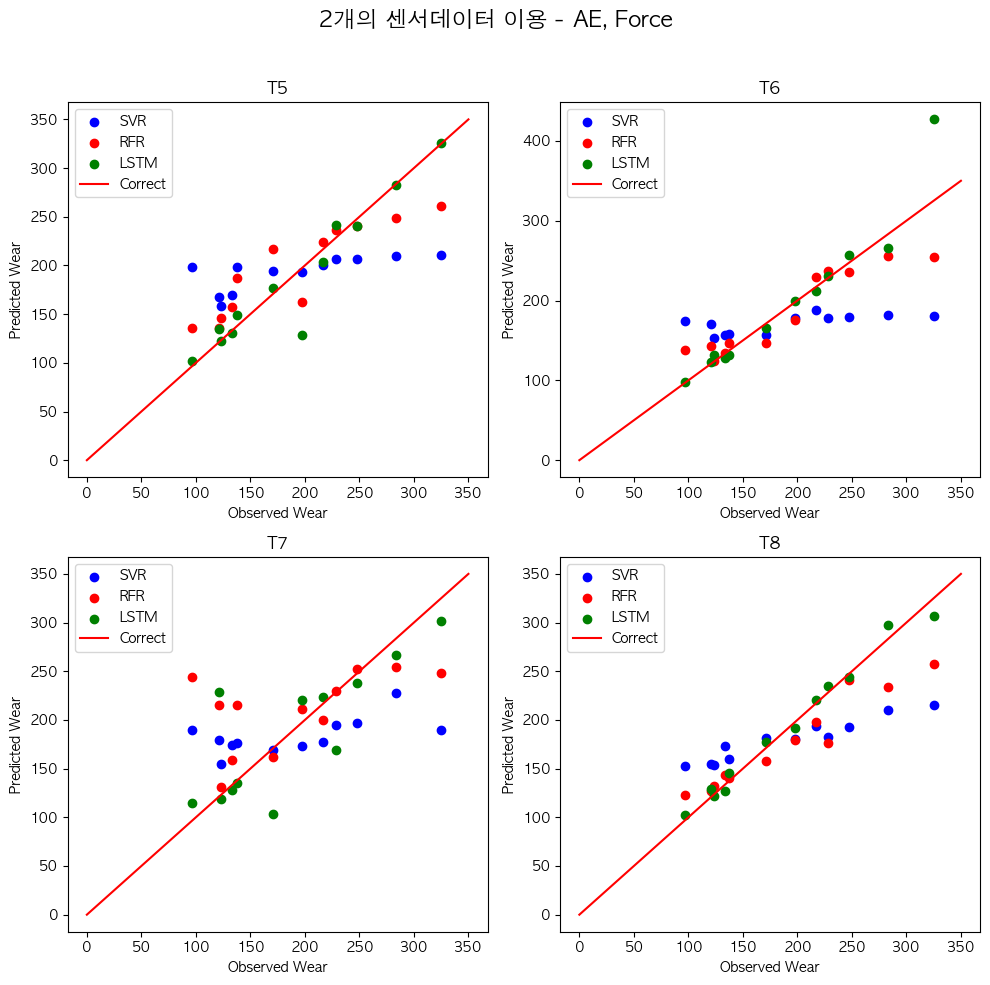

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    axs[i].scatter(svr_aef_results[f'T{i+5}'][0], svr_aef_results[f'T{i+5}'][1], label='SVR', color='blue')
    axs[i].scatter(rfr_aef_results[f'T{i+5}'][0], rfr_aef_results[f'T{i+5}'][1], label='RFR', color='red')
    axs[i].scatter(lstm_aef_results[f'T{i+5}'][0], lstm_aef_results[f'T{i+5}'][1], label='LSTM', color='green')
    axs[i].plot([0, 350], [0, 350], 'r-', label='Correct')
    axs[i].set_xlabel('Observed Wear')
    axs[i].set_ylabel('Predicted Wear')
    axs[i].legend()
    axs[i].set_title(f'T{i+5}')

fig.suptitle('2개의 센서데이터 이용 - AE, Force', fontsize=16)
# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

# 여러 결과 시각화

### Figure 17

In [93]:
def figure_17(k):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()


    axs[0].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][0], label='True wear', color='blue')

    axs[1].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][0], label='True wear', color='blue')
    axs[1].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][1], label='SVR', color='orange')

    axs[2].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][0], label='True wear', color='blue')
    axs[2].plot([i for i in range(1, 13)], rfr_all_results[f'T{k}'][1], label='RFR', color='gray')

    axs[3].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][0], label='True wear', color='blue')
    axs[3].plot([i for i in range(1, 13)], lstm_all_results[f'T{k}'][1], label='LSTM', color='yellow')

    for i in range(4):
        axs[i].set_xlabel('Milling experiments')
        axs[i].set_ylabel('Flank Wear')
        axs[i].legend()
        axs[i].set_xticks(ticks=range(1, 13))
        

    fig.suptitle(f'모델별 T{k} 예측 결과', fontsize=16)
    # 레이아웃 조정
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 그래프 출력
    plt.show()

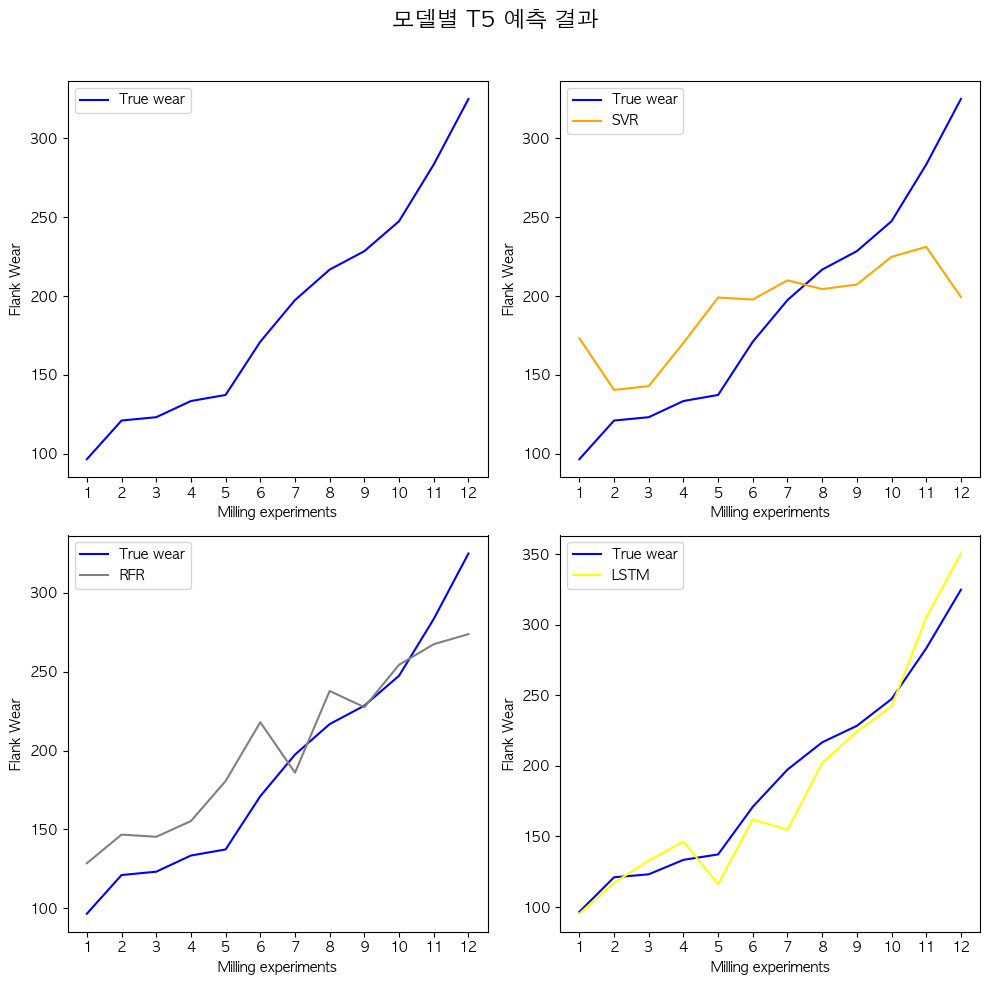

In [94]:
figure_17(5)

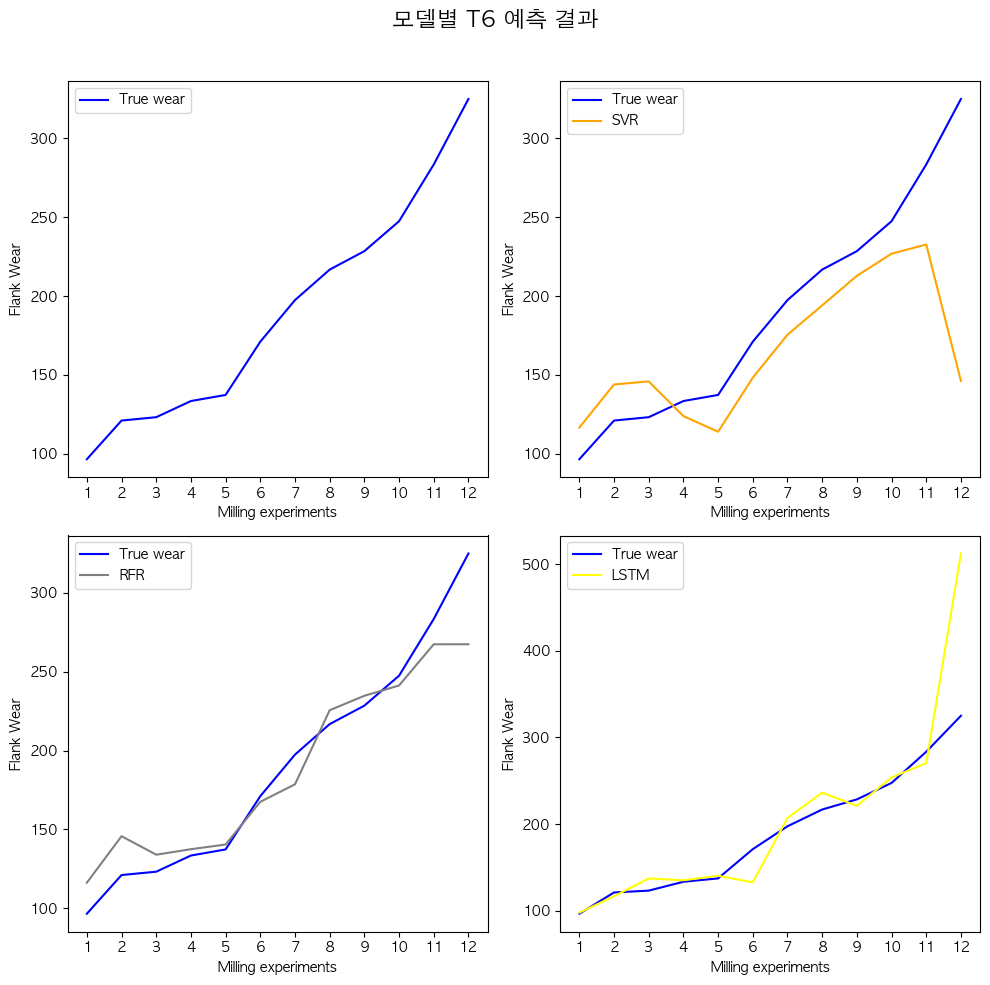

In [95]:
figure_17(6)

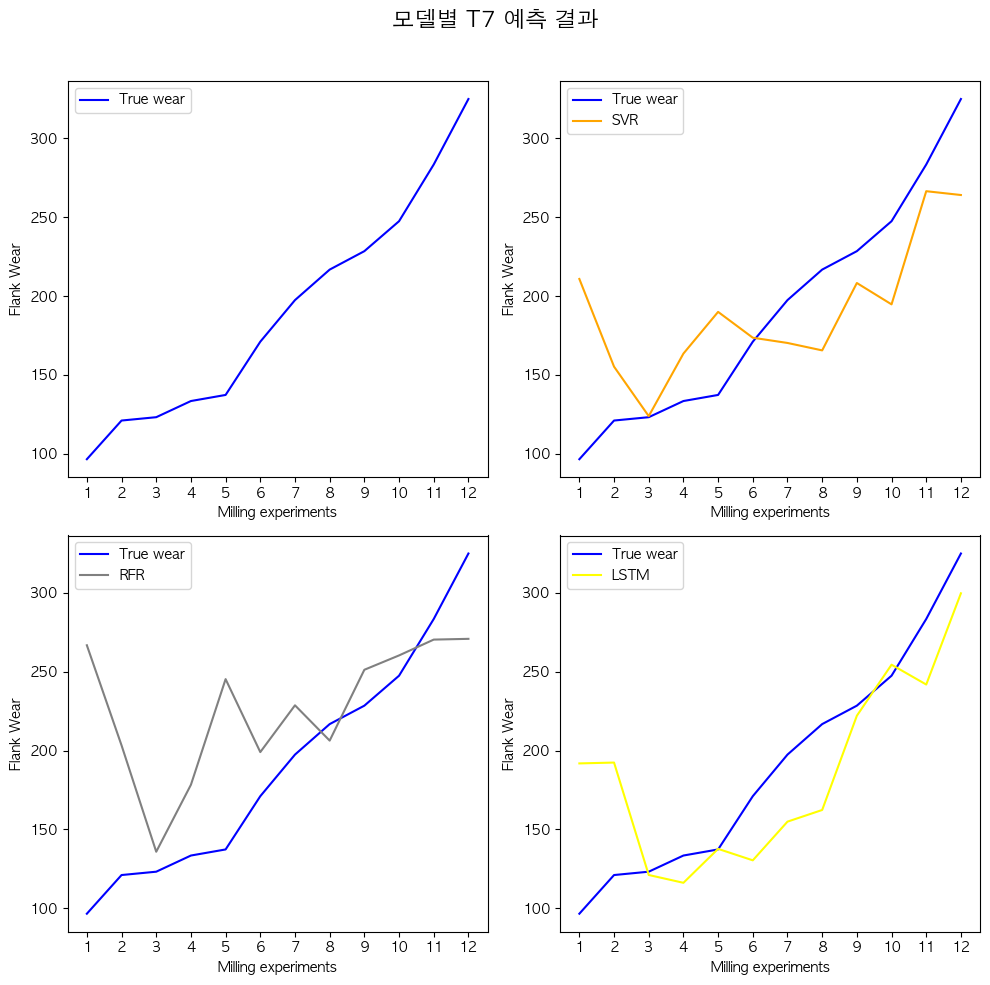

In [96]:
figure_17(7)

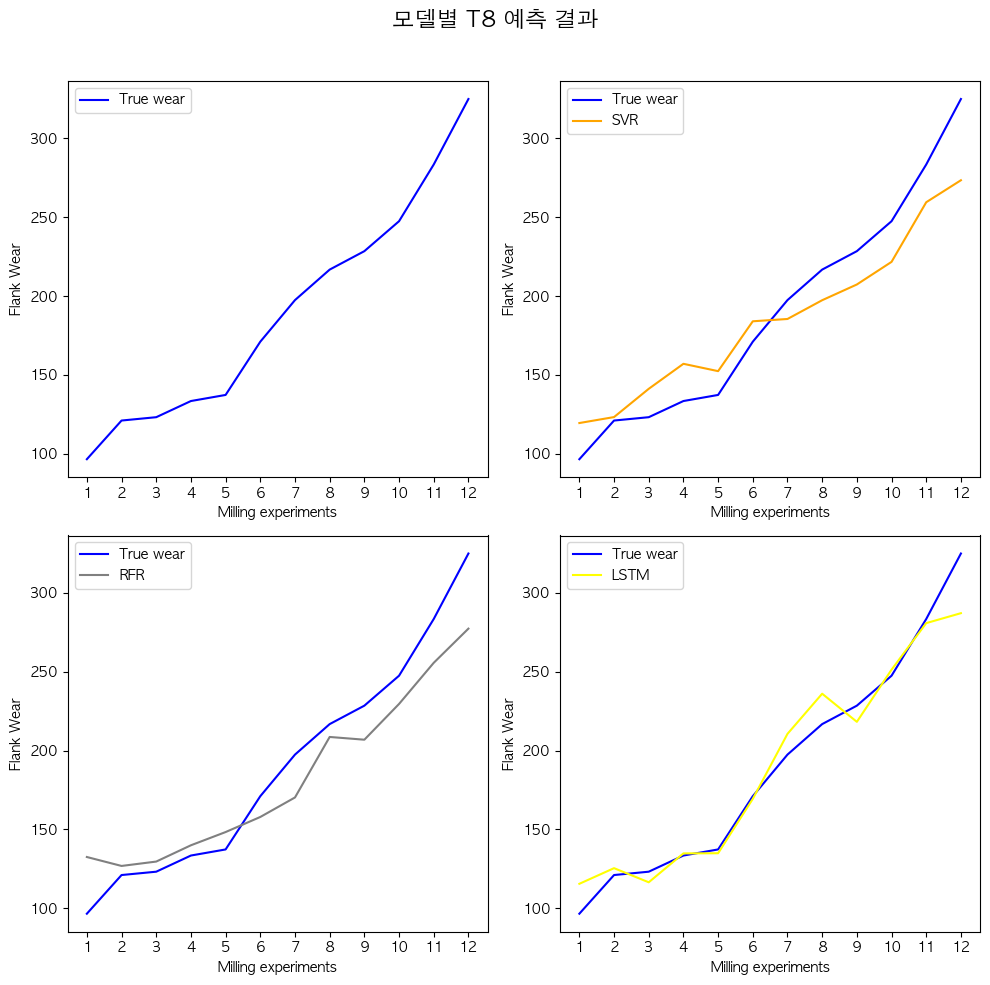

In [97]:
figure_17(8)

### Figure 19

In [103]:
def figure_19(k):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()


    axs[0].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][0], label='True wear', color='blue')
    axs[0].plot([i for i in range(1, 13)], svr_all_results[f'T{k}'][1], label='SVR', color='orange')
    axs[0].plot([i for i in range(1, 13)], rfr_all_results[f'T{k}'][1], label='RFR', color='gray')
    axs[0].plot([i for i in range(1, 13)], lstm_all_results[f'T{k}'][1], label='LSTM', color='yellow')
    axs[0].set_title('All sensors', fontsize=12)

    axs[1].plot([i for i in range(1, 13)], svr_acf_results[f'T{k}'][0], label='True wear', color='blue')
    axs[1].plot([i for i in range(1, 13)], svr_acf_results[f'T{k}'][1], label='SVR', color='orange')
    axs[1].plot([i for i in range(1, 13)], rfr_acf_results[f'T{k}'][1], label='RFR', color='gray')
    axs[1].plot([i for i in range(1, 13)], lstm_acf_results[f'T{k}'][1], label='LSTM', color='yellow')
    axs[1].set_title('Force Dynamometer + Accelerometer', fontsize=12)

    axs[2].plot([i for i in range(1, 13)], svr_acae_results[f'T{k}'][0], label='True wear', color='blue')
    axs[2].plot([i for i in range(1, 13)], svr_acae_results[f'T{k}'][1], label='SVR', color='orange')
    axs[2].plot([i for i in range(1, 13)], rfr_acae_results[f'T{k}'][1], label='RFR', color='gray')
    axs[2].plot([i for i in range(1, 13)], lstm_acae_results[f'T{k}'][1], label='LSTM', color='yellow')
    axs[2].set_title('Accelerometer + AE', fontsize=12)

    axs[3].plot([i for i in range(1, 13)], svr_aef_results[f'T{k}'][0], label='True wear', color='blue')
    axs[3].plot([i for i in range(1, 13)], svr_aef_results[f'T{k}'][1], label='SVR', color='orange')
    axs[3].plot([i for i in range(1, 13)], rfr_aef_results[f'T{k}'][1], label='RFR', color='gray')
    axs[3].plot([i for i in range(1, 13)], lstm_aef_results[f'T{k}'][1], label='LSTM', color='yellow')
    axs[3].set_title('Foce Dynamometer + AE', fontsize=12)

    for i in range(4):
        axs[i].set_xlabel('Milling experiments')
        axs[i].set_ylabel('Flank Wear')
        axs[i].legend()
        axs[i].set_xticks(ticks=range(1, 13))
        
        

    fig.suptitle(f'센서 조합별 T{k} 예측 결과', fontsize=16)
    # 레이아웃 조정
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 그래프 출력
    plt.show()

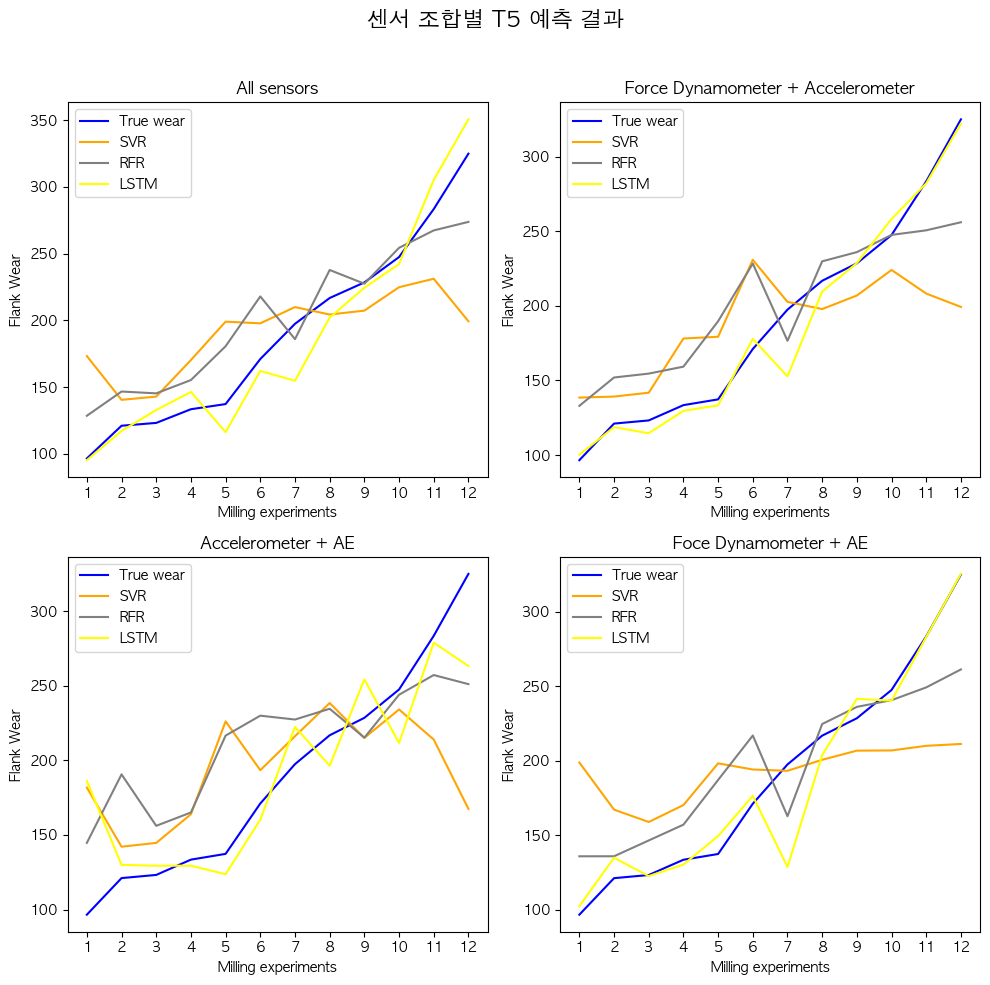

In [104]:
figure_19(5)

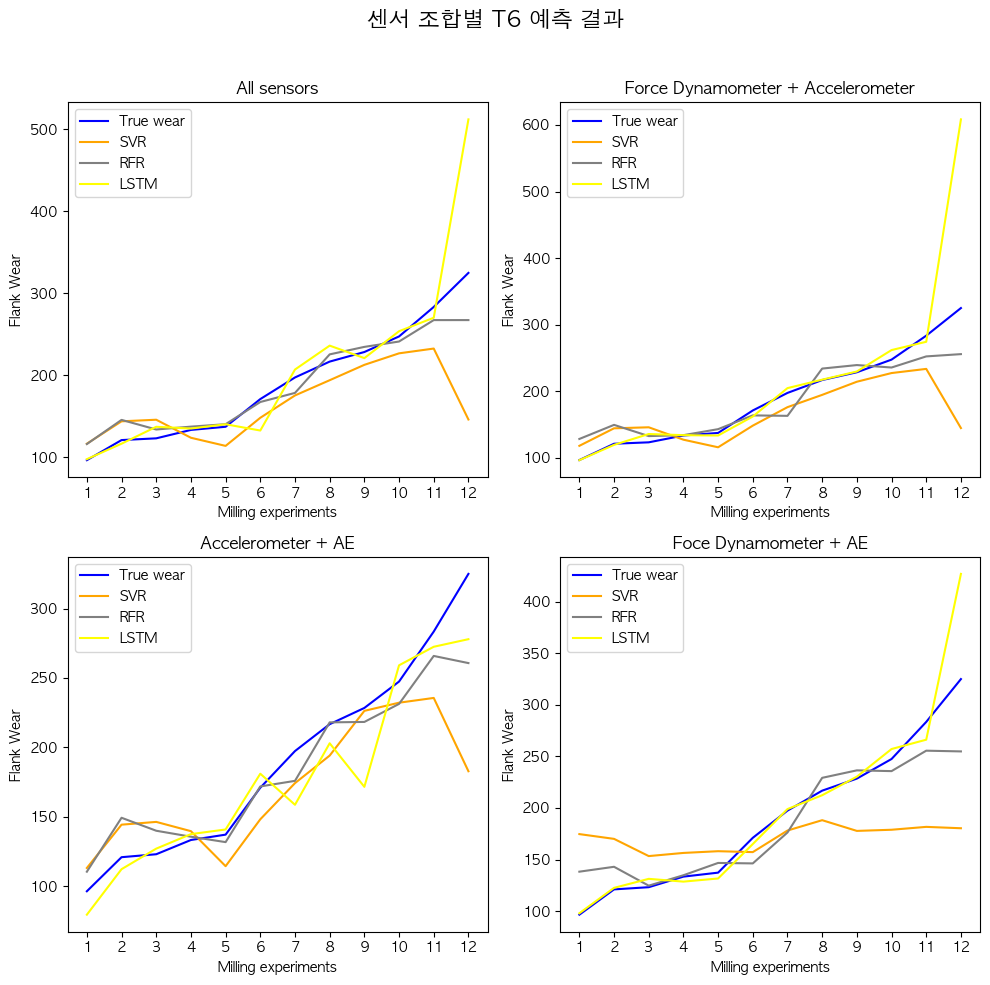

In [105]:
figure_19(6)

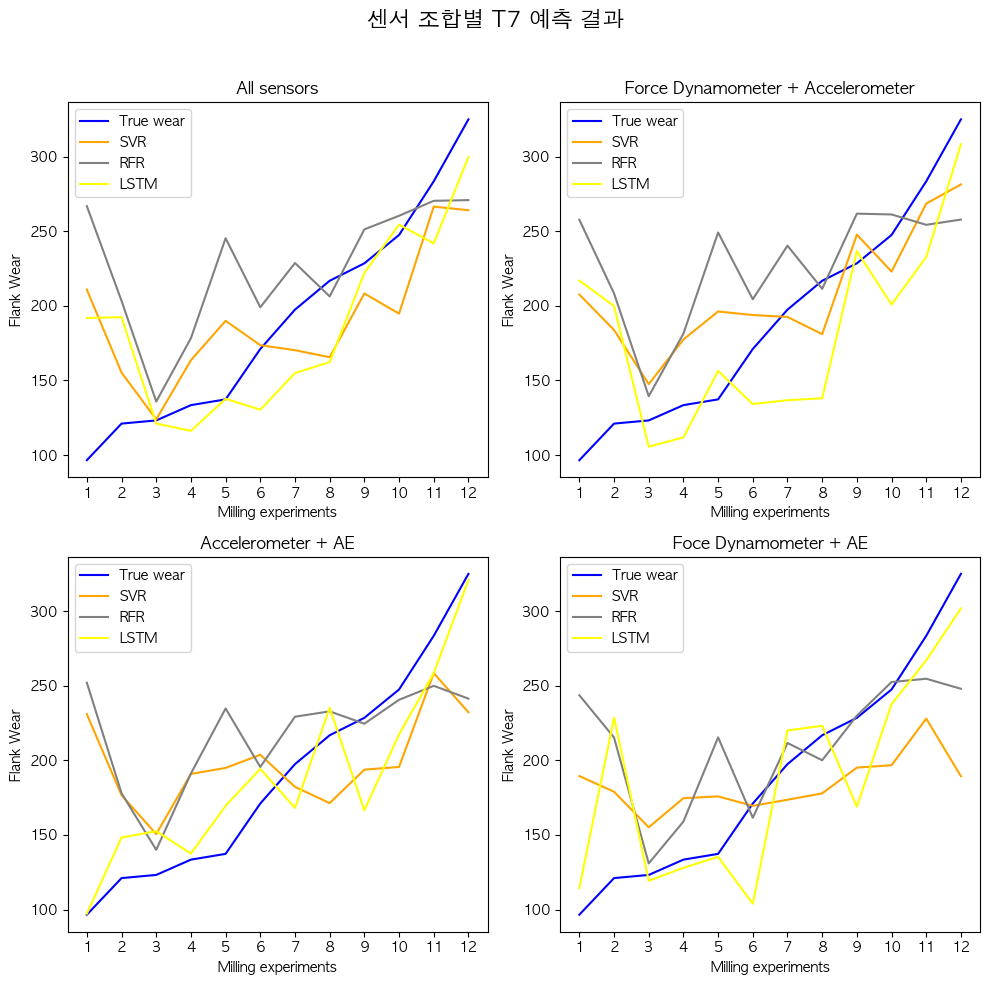

In [101]:
figure_18(7)

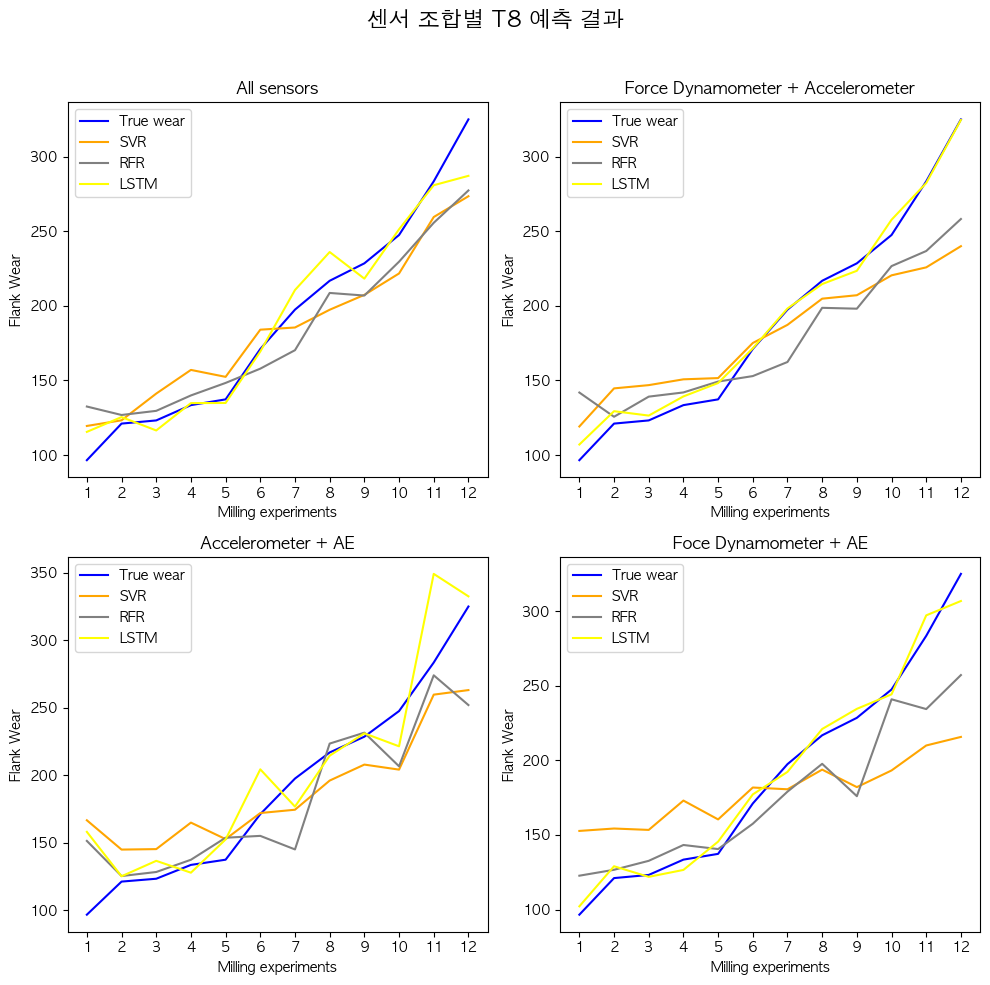

In [106]:
figure_19(8)

### Figure 20

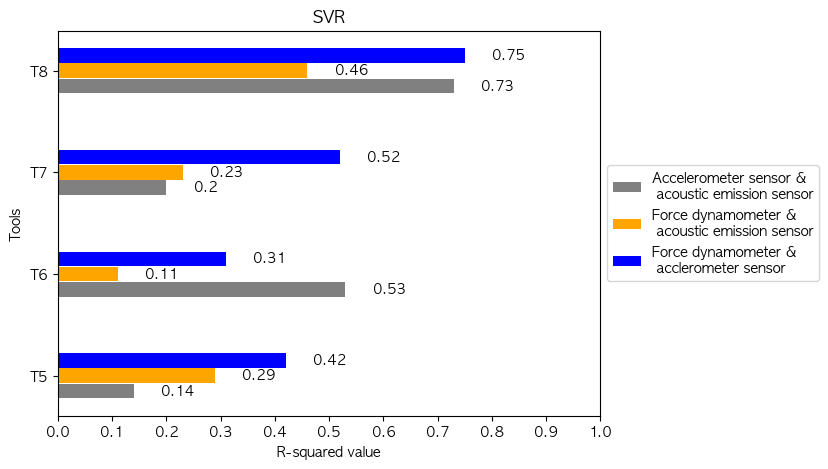

In [143]:
yticks = ['T5', 'T6', 'T7', 'T8']
accelerometer_acoustic = [0.14, 0.53, 0.20, 0.73]
force_acoustic = [0.29, 0.11, 0.23, 0.46]
force_accelerometer = [0.42, 0.31, 0.52, 0.75]

height = 0.15

# 그래프 생성
fig, ax = plt.subplots(1,1,figsize=(7,5))

def compute_pos(yticks, height, i, n):
	index = np.arange(len(yticks))
	correction = i - 0.5*(n-1)
	return index + height * correction

pos = compute_pos(yticks, height, 0, 3)
bar1 = ax.barh(pos, accelerometer_acoustic, height=height*0.95, label='ACC + AE', color='grey')
for i in range(4):  
    ax.text(accelerometer_acoustic[i] + 0.05, pos[i], str(accelerometer_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 1, 3)
bar2 = ax.barh(pod, force_acoustic, height=height*0.95, label='Force + AE', color='orange')
for i in range(4):
    ax.text(force_acoustic[i] + 0.05, pod[i], str(force_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 2, 3)
bar3 = ax.barh(pod, force_accelerometer, height=height*0.95, label='Force + ACC', color='blue')
for i in range(4):
    ax.text(force_accelerometer[i] + 0.05, pod[i], str(force_accelerometer[i]), ha='left', va='center', fontsize=10)


ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_tick_params(labelsize=10)

# y축 레이블 설정
ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks, fontsize=10)	

ax.legend([bar1, bar2, bar3], ['Accelerometer sensor &\n acoustic emission sensor', 'Force dynamometer &\n acoustic emission sensor', 'Force dynamometer &\n acclerometer sensor'], loc='center left', bbox_to_anchor=(1, 0.5))


plt.xlabel('R-squared value')
plt.ylabel('Tools')
plt.title('SVR')

# 그래프 출력
plt.show()


### Figure 21

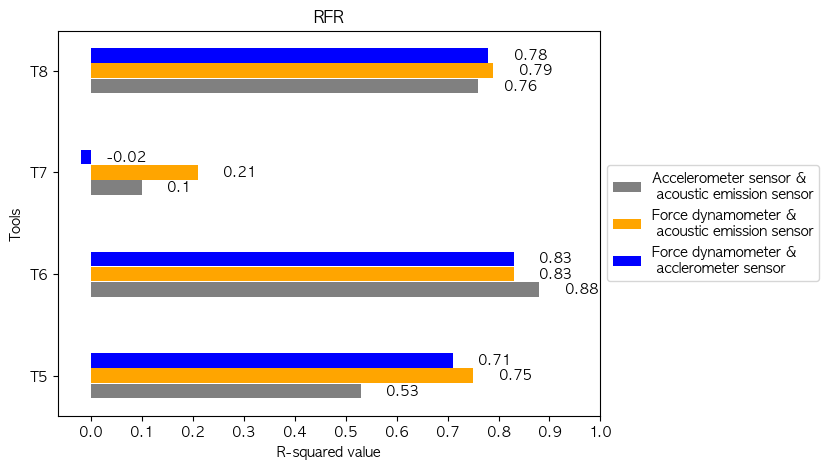

In [140]:
yticks = ['T5', 'T6', 'T7', 'T8']
accelerometer_acoustic = [0.53, 0.88, 0.10, 0.76]
force_acoustic = [0.75, 0.83, 0.21, 0.79]
force_accelerometer = [0.71, 0.83, -0.02, 0.78]

height = 0.15

# 그래프 생성
fig, ax = plt.subplots(1,1,figsize=(7,5))

def compute_pos(yticks, height, i, n):
	index = np.arange(len(yticks))
	correction = i - 0.5*(n-1)
	return index + height * correction

pos = compute_pos(yticks, height, 0, 3)
bar1 = ax.barh(pos, accelerometer_acoustic, height=height*0.95, label='ACC + AE', color='grey')
for i in range(4):  
    ax.text(accelerometer_acoustic[i] + 0.05, pos[i], str(accelerometer_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 1, 3)
bar2 = ax.barh(pod, force_acoustic, height=height*0.95, label='Force + AE', color='orange')
for i in range(4):
    ax.text(force_acoustic[i] + 0.05, pod[i], str(force_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 2, 3)
bar3 = ax.barh(pod, force_accelerometer, height=height*0.95, label='Force + ACC', color='blue')
for i in range(4):
    ax.text(force_accelerometer[i] + 0.05, pod[i], str(force_accelerometer[i]), ha='left', va='center', fontsize=10)


ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_tick_params(labelsize=10)

# y축 레이블 설정
ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks, fontsize=10)	

ax.legend([bar1, bar2, bar3], ['Accelerometer sensor &\n acoustic emission sensor', 'Force dynamometer &\n acoustic emission sensor', 'Force dynamometer &\n acclerometer sensor'], loc='center left', bbox_to_anchor=(1, 0.5))


plt.xlabel('R-squared value')
plt.ylabel('Tools')
plt.title('RFR')

# 그래프 출력
plt.show()

### Figure 22

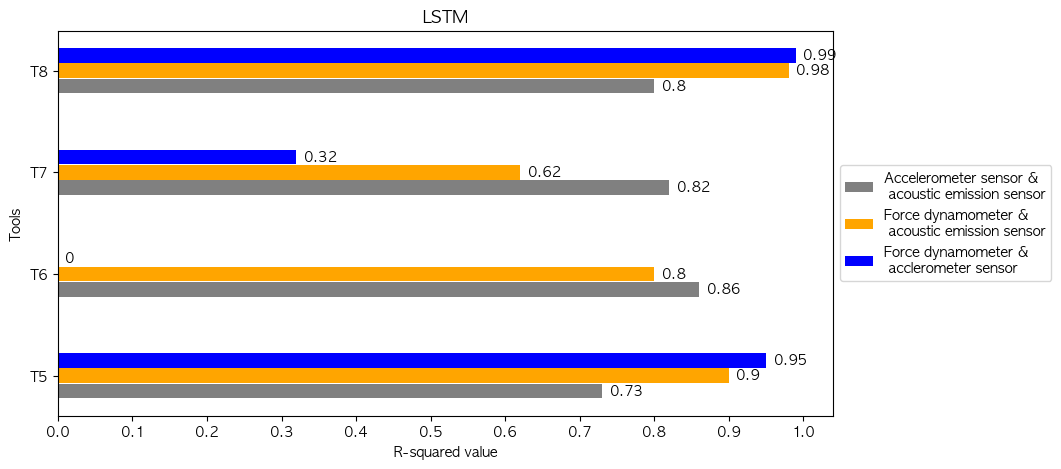

In [149]:
yticks = ['T5', 'T6', 'T7', 'T8']
accelerometer_acoustic = [0.73, 0.86, 0.82, 0.80]
force_acoustic = [0.90, 0.80, 0.62, 0.98]
force_accelerometer = [0.95, 0, 0.32, 0.99]

height = 0.15

# 그래프 생성
fig, ax = plt.subplots(1,1,figsize=(10,5))

def compute_pos(yticks, height, i, n):
	index = np.arange(len(yticks))
	correction = i - 0.5*(n-1)
	return index + height * correction

pos = compute_pos(yticks, height, 0, 3)
bar1 = ax.barh(pos, accelerometer_acoustic, height=height*0.95, label='ACC + AE', color='grey')
for i in range(4):  
    ax.text(accelerometer_acoustic[i] + 0.01, pos[i], str(accelerometer_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 1, 3)
bar2 = ax.barh(pod, force_acoustic, height=height*0.95, label='Force + AE', color='orange')
for i in range(4):
    ax.text(force_acoustic[i] + 0.01, pod[i], str(force_acoustic[i]), ha='left', va='center', fontsize=10)
pod = compute_pos(yticks, height, 2, 3)
bar3 = ax.barh(pod, force_accelerometer, height=height*0.95, label='Force + ACC', color='blue')
for i in range(4):
    ax.text(force_accelerometer[i] + 0.01, pod[i], str(force_accelerometer[i]), ha='left', va='center', fontsize=10)


ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_tick_params(labelsize=10)

# y축 레이블 설정
ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks, fontsize=10)	

ax.legend([bar1, bar2, bar3], ['Accelerometer sensor &\n acoustic emission sensor', 'Force dynamometer &\n acoustic emission sensor', 'Force dynamometer &\n acclerometer sensor'], loc='center left', bbox_to_anchor=(1, 0.5))


plt.xlabel('R-squared value')
plt.ylabel('Tools')
plt.title('LSTM')

# 그래프 출력
plt.show()